In [37]:
import torch
from concurrent.futures import ThreadPoolExecutor

# Morton encoding
def spread_bits(x):
    """Spreading bits for mortion encoding"""
    x &= 0x0000ffff  # Only keep the lowest 16 bits
    x = (x ^ (x << 8)) & 0x00ff00ff
    x = (x ^ (x << 4)) & 0x0f0f0f0f
    x = (x ^ (x << 2)) & 0x33333333
    x = (x ^ (x << 1)) & 0x55555555
    return x

def morton_encode(x, y):
    "Apply morton encoding using bitwise spread function"
    return  (spread_bits(y) << 1) + spread_bits(x)

def encode_block(block, block_index):
    "Process block of points on GPU and return sorted morton encoded array with indices"
    int_points = block.to(torch.int32)
    x, y = int_points[:,0], int_points[:,1]
    morton_codes = morton_encode(x,y)
    indices = torch.arange(block_index*block.shape[0],(block_index+1)*block.shape[0], device= block.device)
    return morton_codes, indices

def morton_encode_sort(points_xy, block_size=1024, max_workers = 8):
    """
    Inputs :- 
        Points_xy        - 2d pytorch tensor with each row representing an (x,y) coordinates.
        block_size (int) - number of points to process for a block 
        max_workers (int)- minimum number of threads to use. (max_workers=4 or 8 to balance efficiency without overloading)
                           Or we can keep ThreadPoolExecutor(max_workers=max_workers) as ThreadPoolExecutor() for the system to assign a number.
                           But specifying a number might give more control.
                           https://www.geeksforgeeks.org/how-to-use-threadpoolexecutor-in-python3/
    Output :- 
        Two 1D arrays with sorted morton encoded value and the corresponding index
    """
    device = points_xy.device
    if device.type == 'cpu':
        if torch.cuda.is_available():
            points_xy = points_xy.to('cuda')
            
    num_blocks = (points_xy.shape[0] + block_size -1)//block_size 

    # List to hold the results
    all_morton_codes = []
    all_indices = []

    # Multithreading
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(encode_block, points_xy[i*block_size:(i+1)*block_size],i) if (i<num_blocks-1) else executor.submit(encode_block, points_xy[i*block_size:],i)
                  for i in range(num_blocks)]
        # Collecting results from each block
        for f in futures:
            morton_codes, indices = f.result()
            all_morton_codes.append(morton_codes)
            all_indices.append(indices)
    
    # Concatenate and sort
    all_morton_codes = torch.cat(all_morton_codes)
    all_indices = torch.cat(all_indices)
    final_sorted_indices = torch.argsort(all_morton_codes)

    return all_morton_codes[final_sorted_indices], all_indices[final_sorted_indices]
    


In [66]:
# Example usage
torch.manual_seed(0)
points_xy = torch.rand(5000, 2, device="cuda") * 1024  # Generate points on GPU

# Run the function
sorted_morton_codes, sorted_indices = morton_encode_sort(points_xy)
print(sorted_morton_codes[:10].cpu().numpy(), sorted_indices[:10].cpu().numpy())

[ 158  279  581  863  941 1037 1425 1658 1914 2089] [3615 3826 2339 4093 1546 3763 3327  913  156  259]


sorted_morton_codes = [ 3  6  7  9 11 12 13 14 15 18 24 26 33 36 37 48], sorted_indices = [ 8 12  0  9 10 13  1 14  2  4  5  6 11 15  3  7]


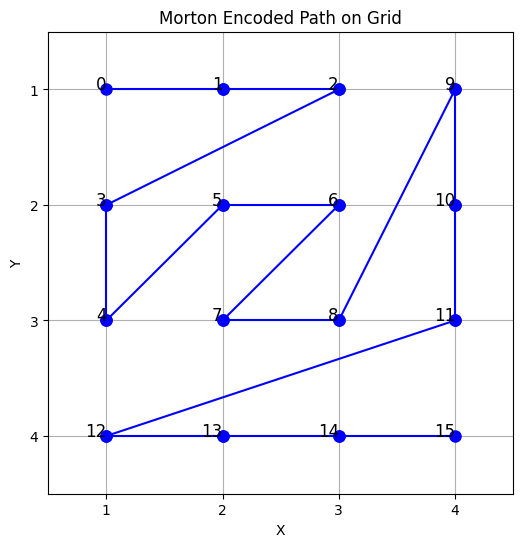

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Example usage
torch.manual_seed(0)
points_xy = torch.tensor([[3,1],[3,2],[3,3],[3,4],[4,1],[4,2],[4,3],[4,4],[1,1],[1,2],[1,3],[1,4],[2,1],[2,2],[2,3],[2,4]])

# Run the function
sorted_morton_codes, sorted_indices = morton_encode_sort(points_xy)
print(f"sorted_morton_codes = {sorted_morton_codes[:16].cpu().numpy()}, sorted_indices = {sorted_indices[:16].cpu().numpy()}")

# Define the grid points and corresponding Morton order (sorted by Morton codes)
points = points_xy.cpu().numpy()
sorted_indices_cpu = sorted_indices.cpu()

# Get points in Morton order
morton_order_points = points[sorted_indices_cpu]

# Plot the grid points
plt.figure(figsize=(6, 6))
plt.grid(True)
plt.xticks(range(1, 6))
plt.yticks(range(1, 6))
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)

# Draw the Morton path by connecting points in Morton order
for i in range(len(morton_order_points) - 1):
    x_vals = [morton_order_points[i][0], morton_order_points[i + 1][0]]
    y_vals = [morton_order_points[i][1], morton_order_points[i + 1][1]]
    plt.plot(x_vals, y_vals, 'bo-', markersize=8)

# Label the points in the Morton traversal order
for i, (x, y) in enumerate(morton_order_points):
    plt.text(x, y, str(i), fontsize=12, ha='right')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Morton Encoded Path on Grid")
plt.gca().invert_yaxis()  # Optional: invert y-axis for matrix-style view
plt.show()

In [50]:

class Box:
    def __init__(self, morton_encoded_sorted_values, morton_indices, points_xy): # These arrays belongs to this box
        self.morton_vals = morton_encoded_sorted_values # Morton encoded values
        self.morton_indices = morton_indices    # Morton encoded indices
        self.points_xy = points_xy              # Points xy values (for the points inside the box), these xy values are in order correspondinhg to respective morton encoded val and index
        self.min_m = morton_encoded_sorted_values[0]  # minimum mortom val
        self.max_m = morton_encoded_sorted_values[-1] # maximum morton val
    def get_box_min_max(self):
        device = self.points_xy.device
        if device.type == 'cpu':
            self.points_xy = self.points_xy.to('cuda')
        min_val,_ = torch.min(self.points_xy,dim=0)
        max_val,_ = torch.max(self.points_xy,dim=0)
        self.min_x, self.min_y = min_val[0], min_val[1]
        self.max_x, self.max_y = max_val[0], max_val[1]
    def get_dist_from_point(self, point):
        p_x, p_y = point[0], point[1]   # Imagining point is a torch tensor
        d_x, d_y = 0, 0
        if (self.min_x > p_x) or (self.max_x < p_x):    # Check whether the point's x cooordinate is outside the margine
            d_x = min(abs(self.min_x - p_x), abs(self.max_x - p_x))
        if (self.min_y > p_y) or (self.max_y < p_y):    # Check whether the point's y cooordinate is outside the margine
            d_y = min(abs(self.min_y - p_y), abs(self.max_y - p_y))
        return d_x**2 + d_y**2
    def get_dist(point_1, point_2):
        d_x = point_1[0] - point_2[0]
        d_y = point_1[1] - point_2[1]
        return d_x**2 + d_y**2
    def upate_point_knn_with_box(self, point, blob_idx, knn_dist_arr, knn_idx_arr):
        k_max, k_max_idx = torch.max(knn_dist_arr[blob_idx],dim=0)
        if self.get_dist_from_point(point) < k_max :
            for i, box_point in enumerate(self.points_xy):
                dist = self.get_dist(point, box_point)
                if dist < k_max:
                    knn_dist_arr[blob_idx][k_max_idx] = dist
                    knn_idx_arr[blob_idx][k_max_idx] = self.morton_indices[i]
                    k_max, k_max_idx = torch.max(knn_dist_arr[blob_idx],dim=0)



In [62]:
# Final knn
def update_knn_arr(knn_idx_arr, knn_dist_arr, blob_point_xy, box_point_xy, box_point_idx, blob_xy_idx):
    """
    box_point_idx - this is the original index of the xy value in gaussian point array (This can be extracted from sorted_morton_indices arrays)
    """
    d_x = blob_point_xy[0] - box_point_xy[0]
    d_y = blob_point_xy[1] - box_point_xy[1]
    dist = d_x**2 + d_y**2
    max_dist, max_id = torch.max(knn_dist_arr[blob_xy_idx],dim=0)
    if max_dist > dist:
        knn_dist_arr[blob_xy_idx][max_id] = dist
        knn_idx_arr[blob_xy_idx][max_id] = box_point_idx
    return knn_idx_arr, knn_dist_arr


def get_init_knn_for_points(sorted_blob_morton_codes, sorted_blob_indices, blob_xy, boxes, k):
    """
    sorted_blob_morton_codes :- sorted blob morton codes 
    sorted_blob_indices :- sorted indices according to the morton codes 
    blob_xy :- xy array of all the blobs (not sorted)

    Outputs
        knn_idx_arr = index w.r.t original gaussian array of the knn points
        knn_dist_arr = knn distance array
    """
    blob_idx, box_idx, id_pointer = 0, 0, 0
    num_blobs = sorted_blob_morton_codes.shape[0]
    knn_idx_arr = torch.full((num_blobs,k), 0, dtype=torch.int32)
    knn_dist_arr = torch.full((num_blobs,k),  torch.inf, dtype=torch.float32)
    while (box_idx<len(boxes)) and (blob_idx < num_blobs):
        box = boxes[box_idx]
        blob_morton_val = sorted_blob_morton_codes[blob_idx]
        if (box.min_m < blob_morton_val < box.max_m) or (blob_idx==0 and box_idx==0) or (blob_idx== num_blobs-1 and box_idx==len(boxes)-1):
            p = box.points_xy.shape[0]
            while id_pointer<p:
                if (blob_morton_val > box.morton_vals[id_pointer]) or (blob_idx==0 and box_idx==0):
                    for n_id in range(max(0,id_pointer-k),min(p,id_pointer+k)):
                        blob_point_xy = blob_xy[sorted_blob_indices[blob_idx]]
                        box_point_xy = box.points_xy[n_id]
                        knn_idx_arr, knn_dist_arr = update_knn_arr(knn_idx_arr, knn_dist_arr, blob_point_xy, box_point_xy, box.morton_indices[n_id], sorted_blob_indices[blob_idx])
                    blob_idx +=1
                    break
                id_pointer = id_pointer +1 
                if id_pointer == p:
                    id_pointer = 0
                    box_idx +=1
                    break
        else:
            box_idx +=1
    return knn_idx_arr, knn_dist_arr


def get_2d_knn(blob_xy, gauss_xy, k=10):
    """ 
    Inputs
        blob_xy :- xy coordinates array of the blobs
        gauss_xy :- 2d xy coordinates array of the gaussians
    Outputs
        knn_idx_arr = index w.r.t original gaussian array of the knn points
        knn_dist_arr = knn distance array
    """
    sorted_gauss_morton_codes, sorted_gauss_indices = morton_encode_sort(gauss_xy)
    sorted_blob_morton_codes, sorted_blob_indices = morton_encode_sort(blob_xy)
    """
    print(f"sorted_gauss_morton_codes = {sorted_gauss_morton_codes}")
    print(f"sorted_gauss_indices = {sorted_gauss_indices}")
    print(f"sorted_blob_morton_codes = {sorted_blob_morton_codes}")
    print(f"sorted_blob_indices = {sorted_blob_indices}")"""
    box_size = 4#1024
    max_workers = 4#8
    P = gauss_xy.shape[0]
    num_box = (P + box_size -1)//box_size

    # Create and configure boxes based on Morton codes
    boxes = []
    for i in range(num_box):
        morton_encoded_sorted_values = sorted_gauss_morton_codes[i*box_size : min((i+1)*box_size, P)]
        morton_indices = sorted_gauss_indices[i*box_size : min((i+1)*box_size, P)]
        points_xy = gauss_xy[morton_indices]
        boxes.append(Box(morton_encoded_sorted_values, morton_indices, points_xy))
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for box in boxes:
            executor.submit(box.get_box_min_max)
    knn_idx_arr, knn_dist_arr = get_init_knn_for_points(sorted_blob_morton_codes, sorted_blob_indices, blob_xy, boxes, k)
    #print(f"initial indexes = {knn_idx_arr}")
    
    # Further update the knn arrays
    def update_knn_for_boxes(point, blob_xy_idx):   
        with ThreadPoolExecutor(max_workers=max_workers) as inner_executor:
            for box in boxes:
                inner_executor.submit(box.upate_point_knn_with_box, point, blob_xy_idx, knn_dist_arr, knn_idx_arr)
    with ThreadPoolExecutor(max_workers=max_workers) as outer_executor:
        for i in range(blob_xy.shape[0]):
            outer_executor.submit(update_knn_for_boxes, blob_xy[i], i)
    return knn_idx_arr, knn_dist_arr
    



In [63]:
import torch
import time

# Generate random 2D points as test data
num_points_blob = 100
num_points_gauss = 200
blob_xy = torch.randint(0, 400, (num_points_blob, 2), dtype=torch.int32)
gauss_xy = torch.randint(0, 400, (num_points_gauss, 2), dtype=torch.int32)

k = 5  # Number of nearest neighbors

# Time the Morton-encoded k-NN approach
start_time = time.time()
knn_idx_arr, knn_dist_arr = get_2d_knn(blob_xy, gauss_xy,k)
morton_knn_time = time.time() - start_time

# Time the brute-force k-NN approach using torch.cdist
def brute_force_knn(blob_xy, gauss_xy, k):
    dists = torch.cdist(blob_xy.float(), gauss_xy.float(), p=2)  # Compute pairwise Euclidean distances
    knn_dists, knn_indices = torch.topk(dists, k, dim=1, largest=False)
    return knn_indices, knn_dists

start_time = time.time()
brute_knn_idx, brute_knn_dist = brute_force_knn(blob_xy, gauss_xy, k)
brute_knn_time = time.time() - start_time

# Calculate accuracy by checking if the indices of knn_idx_arr are close to brute_knn_idx
accuracy = (knn_idx_arr == brute_knn_idx).float().mean() * 100
print(f"Accuracy of Morton-encoded k-NN: {accuracy:.2f}%")

# Optional: Check individual distances for a more precise accuracy metric
dist_diff = (knn_dist_arr - brute_knn_dist).abs().mean().item()
print(f"Mean distance difference between methods: {dist_diff:.4f}")

# Print the runtime of both methods
print(f"Morton-encoded k-NN time: {morton_knn_time:.4f} seconds")
print(f"Brute-force k-NN time: {brute_knn_time:.4f} seconds")

print(f"knn_idx_arr = {knn_idx_arr}")
print(f"brute_knn_idx = {brute_knn_idx}")



Accuracy of Morton-encoded k-NN: 1.20%
Mean distance difference between methods: inf
Morton-encoded k-NN time: 4.0121 seconds
Brute-force k-NN time: 0.0005 seconds
knn_idx_arr = tensor([[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0

In [68]:
import torch
a = torch.randn(5,3)*10
b = torch.randint(low=0, high=5, size=(4,4))
print(a)
print(b)
print(a[b])
print(torch.mean(torch.tensor(b,dtype=torch.float32),dim=0))



tensor([[ 10.4448, -24.8639,  -0.8285],
        [  4.5359,  -9.8088,   7.7915],
        [  1.3738,  -1.6888,  -7.0880],
        [ -5.1999,  -7.7388,   5.8729],
        [  5.4469,  -7.3831,   5.6750]])
tensor([[2, 2, 4, 1],
        [1, 4, 3, 3],
        [0, 3, 1, 0],
        [2, 1, 4, 0]])
tensor([[[  1.3738,  -1.6888,  -7.0880],
         [  1.3738,  -1.6888,  -7.0880],
         [  5.4469,  -7.3831,   5.6750],
         [  4.5359,  -9.8088,   7.7915]],

        [[  4.5359,  -9.8088,   7.7915],
         [  5.4469,  -7.3831,   5.6750],
         [ -5.1999,  -7.7388,   5.8729],
         [ -5.1999,  -7.7388,   5.8729]],

        [[ 10.4448, -24.8639,  -0.8285],
         [ -5.1999,  -7.7388,   5.8729],
         [  4.5359,  -9.8088,   7.7915],
         [ 10.4448, -24.8639,  -0.8285]],

        [[  1.3738,  -1.6888,  -7.0880],
         [  4.5359,  -9.8088,   7.7915],
         [  5.4469,  -7.3831,   5.6750],
         [ 10.4448, -24.8639,  -0.8285]]])
tensor([1.2500, 2.5000, 3.0000, 1.0000])


/tmp/ipykernel_624935/2516141573.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.mean(torch.tensor(b,dtype=torch.float32),dim=0))


In [85]:
import numpy as np
a= np.array([1,2,3])
a= torch.tensor(a[:2])
print(a)

tensor([1, 2])


In [83]:
c = torch.randint(low=0, high=5, size=(4,2,3))
print(c)
print(torch.mean(torch.tensor(c.clone().detach(),dtype=torch.float32),dim=1))

tensor([[[4, 3, 0],
         [2, 3, 0]],

        [[3, 2, 3],
         [0, 3, 3]],

        [[0, 1, 4],
         [4, 1, 0]],

        [[4, 2, 1],
         [0, 2, 4]]])
tensor([[3.0000, 3.0000, 0.0000],
        [1.5000, 2.5000, 3.0000],
        [2.0000, 1.0000, 2.0000],
        [2.0000, 2.0000, 2.5000]])


/tmp/ipykernel_624935/1350124515.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.mean(torch.tensor(c.clone().detach(),dtype=torch.float32),dim=1))


In [79]:
a = torch.randn(5,3)*10
print(a)
d=torch.empty_like(a)
d[:,0],d[:,1] = a[:,1], a[:,0] 
print(d)

tensor([[ -3.0317,   9.8801,   0.1154],
        [ -0.5912,   2.8596,  -3.1935],
        [  3.2701,   5.9887,  -1.0397],
        [ -0.7499, -13.3720, -15.3742],
        [-11.0442, -19.3496, -11.4513]])
tensor([[  9.8801,  -3.0317,   0.0000],
        [  2.8596,  -0.5912,   0.0000],
        [  5.9887,   3.2701,   0.0000],
        [-13.3720,  -0.7499,   0.0000],
        [-19.3496, -11.0442,   0.0000]])
